In [1]:
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-d6cx4o3d
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-d6cx4o3d
  Resolved https://github.com/openai/CLIP.git to commit 3702849800aa56e2223035bccd1c6ef91c704ca8
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 2.6 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=1518a0442cc4cbe6ab82ac94f09570a81eed1b7d07f53356910db988342caf86
  Stored in directory: /tmp/pip-ephem-wheel-cache-t8as14wj/wheels/ab/4f/3a/5e51521b55997aa6f0690e095c08824219753128ce8d9969a3
Successfully built clip


In [2]:
import torch
import clip
from PIL import Image
import os
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torchvision.transforms as tt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.utils import make_grid
import matplotlib
import torchvision.transforms as T
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 215MiB/s]


In [4]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

  0%|          | 0/135107811 [00:00<?, ?it/s]

In [5]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [6]:
data_dir = './data/cifar10'

train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor()])
valid_tfms = tt.Compose([tt.ToTensor()])

train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

random_seed = 42
torch.manual_seed(random_seed)

In [7]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size*2)

In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, images, labels):
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, images, labels): 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(valid_dl, device)

In [12]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.clip = clip_model.visual
        self.network = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10))
        
    def forward(self, xb):
        xb = self.clip(xb)
        return self.network(xb)

In [13]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (clip): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
 

In [14]:
transform = T.ToPILImage()

In [15]:
from tqdm import tqdm
import copy

transform = T.ToPILImage()

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = list()
    for images, labels in tqdm(val_loader):
      new_images = []
      for i, image in enumerate(images):
        image_input = preprocess(transform(image)).unsqueeze(0).to(device)
        image_input = image_input.squeeze()
        new_images.append(np.asarray(image_input.cpu()))
      new_images = np.asarray(new_images)
      new_images = torch.from_numpy(new_images)
      new_images = new_images.to(device)
      labels = labels.to(device)
      outputs.append(model.validation_step(new_images, labels))
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# without freezing fine tune

In [16]:
def fit(epochs, lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for images, labels in tqdm(train_loader):
            new_images = []
            for i, image in enumerate(images):
              image_input = preprocess(transform(image)).unsqueeze(0).to(device)
              image_input = image_input.squeeze()
              new_images.append(np.asarray(image_input.cpu()))
            new_images = np.asarray(new_images)
            new_images = torch.from_numpy(new_images)

            new_images = new_images.to(device)
            loss = model.training_step(new_images, labels)
            train_losses.append(loss)
            loss.backward()
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [17]:
model = Cifar10CnnModel()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)
epochs = 10
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [18]:
if torch.cuda.is_available():
  model = model.type(torch.cuda.FloatTensor)
history = fit(epochs, max_lr, model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

100%|██████████| 157/157 [00:56<00:00,  2.77it/s]


Epoch [0], last_lr: 0.00003, train_loss: 0.5265, val_loss: 0.3382, val_acc: 0.8928


100%|██████████| 157/157 [00:56<00:00,  2.78it/s]


Epoch [1], last_lr: 0.00008, train_loss: 0.4608, val_loss: 0.4722, val_acc: 0.8497


100%|██████████| 157/157 [00:55<00:00,  2.81it/s]


Epoch [2], last_lr: 0.00010, train_loss: 0.5480, val_loss: 0.5511, val_acc: 0.8096


100%|██████████| 157/157 [00:56<00:00,  2.79it/s]


Epoch [3], last_lr: 0.00010, train_loss: 0.5017, val_loss: 0.4472, val_acc: 0.8448


100%|██████████| 157/157 [00:56<00:00,  2.78it/s]


Epoch [4], last_lr: 0.00008, train_loss: 0.4207, val_loss: 0.4102, val_acc: 0.8614


100%|██████████| 157/157 [00:55<00:00,  2.81it/s]


Epoch [5], last_lr: 0.00006, train_loss: 0.3295, val_loss: 0.3669, val_acc: 0.8742


100%|██████████| 157/157 [00:56<00:00,  2.78it/s]


Epoch [6], last_lr: 0.00004, train_loss: 0.2330, val_loss: 0.2338, val_acc: 0.9200


100%|██████████| 157/157 [00:56<00:00,  2.79it/s]


Epoch [7], last_lr: 0.00002, train_loss: 0.1392, val_loss: 0.1999, val_acc: 0.9368


100%|██████████| 157/157 [00:56<00:00,  2.79it/s]


Epoch [8], last_lr: 0.00000, train_loss: 0.0760, val_loss: 0.1731, val_acc: 0.9484


100%|██████████| 157/157 [00:56<00:00,  2.79it/s]


Epoch [9], last_lr: 0.00000, train_loss: 0.0458, val_loss: 0.1695, val_acc: 0.9522


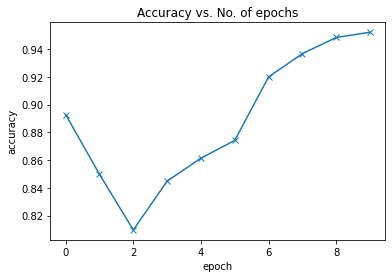

In [19]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

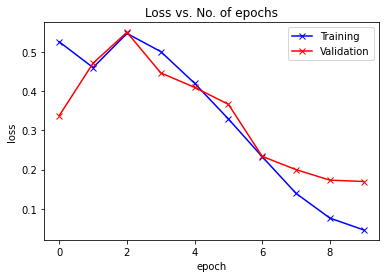

In [20]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

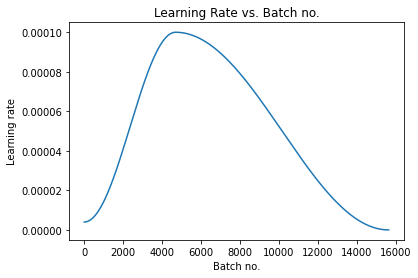

In [21]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')
plot_lrs(history)

In [22]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

100%|██████████| 157/157 [00:56<00:00,  2.78it/s]


{'val_loss': 0.16948139667510986, 'val_acc': 0.9522293210029602}

In [23]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')
model2 = to_device(Cifar10CnnModel(), device)
model2.load_state_dict(torch.load('cifar10-cnn.pth'))

<All keys matched successfully>